<span style="font-family: 'Avenir'; font-size: 18px; line-height: 1.5;">

**CopperMap:** *Enhancing Success in Ullmann Couplings*

For comprehensive details about the experimental, computational, and modeling aspects, please refer to our manuscript on [ChemRxiv](https://chemrxiv.org/engage/chemrxiv/article-details/6532eb5cc3693ca993c1ce40).

M. Samha,# L. J. Karas,# D. Vogt, E. Odogwu, J. Elward, J. Crawford, J. Steves, M. S. Sigman. Predicting Success in Cu-Catalyzed C–N Coupling Reactions using Data Science. ChemRxiv, 2023. DOI: 10.26434/chemrxiv-2023-f50w6.

**Key Features:**

- **Target Reaction:** CopperMap was trained for predicting combinations of primary amines and aryl-bromides in Ullmann couplings.
- **Average Accuracy:** CopperMap achieved an average accuracy of 87% in predicting on/off reactivity (below or above 20% yield) using a dataset of approximately 1000 data points.
- **Library Composition:** The compound library includes 497 primary amines and 385 aryl-bromides.
- **Customization:** If your desired substrate is not in the library, consider simplifying the search by focusing on the immediate core around the amine or aryl-bromide.

Developed by [The Sigman Lab](https://www.sigmanlab.com).

Tool Developer: Lucas Karas; Library Developer: David Vogt; Experimental Results: Moe Samha 


# IMPORTS

In [1]:
from helper_functions import (
    load_pickle,
    plot_confidence_contour,
    convert_to_isomeric_smiles,
    get_input,
    display_structure,
    normalize_and_stack,
    get_confidence_prediction,
    get_nearest_neighbors,
    display_ligands_info,
    get_ligands_info,
    print_product_info,
    draw_reaction_image,
    loaded_x_values,
    loaded_y_values,
    confidence_model,
    knn_model,
    best_ligands,
    x_grid,
    y_grid,
    training_dict,
    br_df,
    amine_df,
    ligands_df,
    ligands,
    display_image,
    workflow
)

# PREDICTION TOOL

<span style="font-family: 'Avenir'; font-size: 18px; line-height: 1.5;">

**Usage Instructions:**

Run the cell below to initiate an iterative process prompting you to enter SMILES strings for the primary amine and aryl-bromide. The system will then display the expected chemical reaction, predict the yield (below or above 20%) with related confidence values, and suggest ligands most likely to work for the given reaction.

If the entered SMILES string is not found in the database, a flag will be raised, indicating that properties for that molecule are not available. In such cases, consider simplifying your compound to contain the core of the primary amine or aryl-bromide.

**Guidelines for Simplifying Compounds:**

- *Primary Amine Property:* The prediction is based on the partial charge in the nitrogen atom (computed as the nitrogen atom's natural populational analysis charge). Therefore, retain substituents that impact the electronics of the nitrogen if possible.

- *Aryl-Bromide Property:* The prediction relies on steric hindrance around the C–Br carbon atom (computed as the buried volume at 2.5Å around the carbon atom). Retain ortho and possibly meta substituents in the aryl ring if possible.
    
**SMILES strings examples for testing:**
    
*Primary amine (aniline)*: NC1=CC=CC=C1     
*Aryl-bromide (bromobenzene)*: BrC1=CC=CC=C1

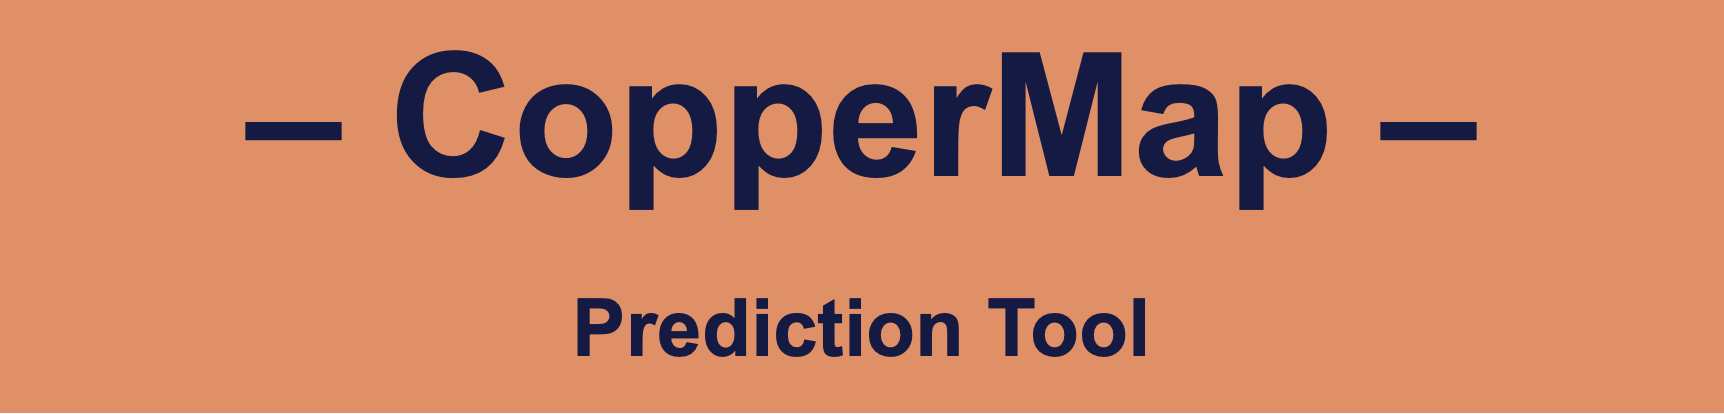

Enter SMILES string of a primary amine in the library: NC1=CC=CC=C1
The value for the entered compound: -0.79202
Enter SMILES string of a aryl-bromide in the library: BrC1=CC=CC=C1
The value for the entered compound: 30.5476

Entered substrates and expected product:


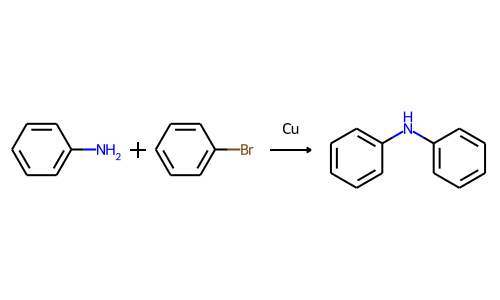

Predicted yield for this reaction is <20% with 95.0% confidence.


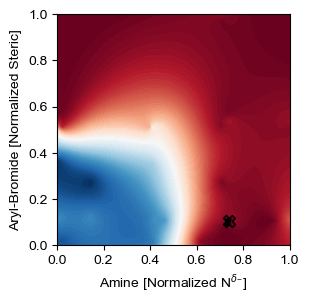

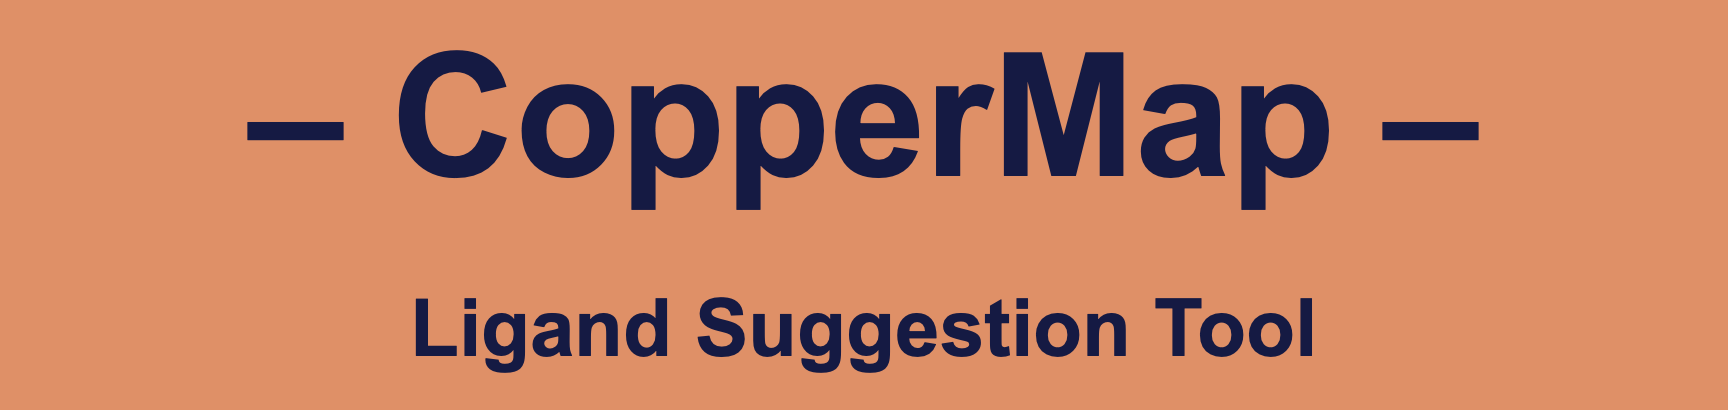


The nearest known product is P110. Best ligands for this product are:
L30 [17.7% yield], L28 [16.8% yield], and L26 [14.1% yield].

The second nearest known product is P118. Best ligands for this product are:
L28 [8.1% yield], L26 [6.7% yield], and L32 [5.4% yield].

Based on that, here are the ligands we suggest trying for this reaction:


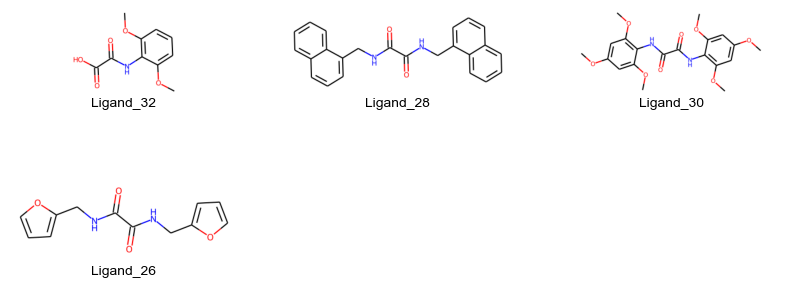

Here are PubChem links for those ligands:
L32: https://pubchem.ncbi.nlm.nih.gov/compound/118864503
L28: https://pubchem.ncbi.nlm.nih.gov/compound/145722499
L30: https://pubchem.ncbi.nlm.nih.gov/compound/126500457
L26: https://pubchem.ncbi.nlm.nih.gov/compound/330826


In [2]:
if __name__ == "__main__":
    workflow()